<a href="https://colab.research.google.com/github/shuyu-wu/bitcoin-prediction/blob/master/GCP_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.cloud import storage
from io import BytesIO
bucket_name = "bitcoin-shuyu"
client = storage.Client()
bucket = client.get_bucket(bucket_name)
content = bucket.blob("btc_tw.csv").download_as_string()

In [0]:
import pandas as pd
# from langdetect import detect, DetectorFactory
import seaborn as sns
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,RNN,GRU,Dropout
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import pickle
from keras.models import load_model
import re
import nltk
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import itertools
# from statsmodels.graphics.tsaplots import plot_pacf
# from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats 
# import statsmodels.api as sm
from itertools import product
# from fbprophet import Prophet
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.
/usr/local/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [0]:
btc_tw_df=pd.read_csv(BytesIO(content))

In [0]:
btc_tw_df.head()

,Unnamed: 0,Unnamed: 0.1,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,negative,neutral,positive,daily_change
0,0,0,2018-07-11 19:35:00,6325.90,6327.93,6299.83,6300.00,285.687119,1.801016e+06,6304.156385,3,31,16,25.90
1,1,1,2018-07-11 19:36:00,6300.95,6304.08,6291.00,6293.04,142.725122,8.989601e+05,6298.541264,4,36,18,7.91
2,2,2,2018-07-11 19:37:00,6293.04,6300.00,6293.04,6295.50,9.574724,6.031536e+04,6299.435459,5,53,18,2.46
3,3,3,2018-07-11 19:38:00,6299.99,6306.99,6299.98,6306.99,130.653981,8.231237e+05,6300.027354,1,40,10,7.00
4,4,4,2018-07-11 19:39:00,6307.89,6312.63,6303.04,6307.96,2.452288,1.546638e+04,6306.917629,3,49,19,0.07


### LSTM without Twitter sentiment analysis: weighted price

In [0]:
btc_tw_df_1 = btc_tw_df[['Timestamp','Weighted_Price']]
btc_tw_df_1.set_index('Timestamp',inplace=True)
btc_tw_df_1.head()

,Weighted_Price
Timestamp,
2018-07-11 19:35:00,6304.156385
2018-07-11 19:36:00,6298.541264
2018-07-11 19:37:00,6299.435459
2018-07-11 19:38:00,6300.027354
2018-07-11 19:39:00,6306.917629


In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [0]:
btc_tw_df_1.isnull().sum()

Weighted_Price    182
dtype: int64

In [0]:
btc_tw_df_1.Weighted_Price = btc_tw_df_1.Weighted_Price.fillna(btc_tw_df_1.Weighted_Price.mean())

/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [0]:
btc_tw_df_1 = scaler.fit_transform(btc_tw_df_1.values)

In [0]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [0]:
n_per_in  = 2
n_per_out = 1
n_features = 1
reframed_df_1 = series_to_supervised(btc_tw_df_1, n_per_in, n_per_out)
reframed_df_1.head()

,var1(t-2),var1(t-1),var1(t)
2,0.112507,0.109612,0.110073
3,0.109612,0.110073,0.110378
4,0.110073,0.110378,0.113930
5,0.110378,0.113930,0.123210
6,0.113930,0.123210,0.123895


In [0]:
values = reframed_df_1.values
n_train_mins = 15000
train = values[:n_train_mins, :]
test = values[n_train_mins:, :]
train.shape

(15000, 3)

In [0]:
X_train, y_train = train[:, :n_per_in*n_features], train[:, -n_features*n_per_out]
X_test, y_test = test[:, :n_per_in*n_features], test[:, -n_features*n_per_out]

In [0]:
X_train = X_train.reshape((X_train.shape[0], n_per_in, n_features))
X_test = X_test.reshape((X_test.shape[0], n_per_in, n_features))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(15000, 2, 1) (15000,) (3041, 2, 1) (3041,)


In [0]:
model = Sequential()
model.add(LSTM(2, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.1))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam',metrics = ['accuracy'])
lstm_model_no_btc = model.fit(X_train, y_train, epochs=10, batch_size=6, validation_data=(X_test, y_test), verbose=2, shuffle=False,validation_split=0.2)

Train on 15000 samples, validate on 3041 samples
Epoch 1/10
 - 16s - loss: 0.0032 - accuracy: 6.6667e-05 - val_loss: 0.0211 - val_accuracy: 3.2884e-04
Epoch 2/10
 - 16s - loss: 0.0052 - accuracy: 6.6667e-05 - val_loss: 0.0162 - val_accuracy: 3.2884e-04
Epoch 3/10
 - 15s - loss: 0.0051 - accuracy: 6.6667e-05 - val_loss: 0.0143 - val_accuracy: 3.2884e-04
Epoch 4/10
 - 15s - loss: 0.0048 - accuracy: 6.6667e-05 - val_loss: 0.0138 - val_accuracy: 3.2884e-04
Epoch 5/10
 - 15s - loss: 0.0047 - accuracy: 6.6667e-05 - val_loss: 0.0186 - val_accuracy: 3.2884e-04
Epoch 6/10
 - 15s - loss: 0.0049 - accuracy: 6.6667e-05 - val_loss: 0.0183 - val_accuracy: 3.2884e-04
Epoch 7/10
 - 15s - loss: 0.0045 - accuracy: 6.6667e-05 - val_loss: 0.0164 - val_accuracy: 3.2884e-04
Epoch 8/10
 - 15s - loss: 0.0042 - accuracy: 6.6667e-05 - val_loss: 0.0148 - val_accuracy: 3.2884e-04
Epoch 9/10
 - 15s - loss: 0.0042 - accuracy: 6.6667e-05 - val_loss: 0.0144 - val_accuracy: 3.2884e-04
Epoch 10/10
 - 15s - loss: 0.0042

### LSTM without Twitter sentiment analysis: daily price change

In [0]:
btc_tw_df_2 = btc_tw_df[['Timestamp','daily_change']]
btc_tw_df_2.set_index('Timestamp',inplace=True)
btc_tw_df_2.head()

,daily_change
Timestamp,
2018-07-11 19:35:00,25.90
2018-07-11 19:36:00,7.91
2018-07-11 19:37:00,2.46
2018-07-11 19:38:00,7.00
2018-07-11 19:39:00,0.07


In [0]:
btc_tw_df_2.daily_change = btc_tw_df_2.daily_change.fillna(btc_tw_df_2.daily_change.mean())

In [0]:
btc_tw_df_2 = scaler.fit_transform(btc_tw_df_2.values)

In [0]:
reframed_df_2 = series_to_supervised(btc_tw_df_2, n_per_in, n_per_out)
reframed_df_2.head()

,var1(t-2),var1(t-1),var1(t)
2,0.265043,0.080946,0.025174
3,0.080946,0.025174,0.071633
4,0.025174,0.071633,0.000716
5,0.071633,0.000716,0.126586
6,0.000716,0.126586,0.031109


In [0]:
values = reframed_df_2.values
n_train_mins = 15000
train_2 = values[:n_train_mins, :]
test_2 = values[n_train_mins:, :]
train_2.shape

(15000, 3)

In [0]:
X_train_2, y_train_2 = train_2[:, :n_per_in*n_features], train_2[:, -n_features*n_per_out]
X_test_2, y_test_2 = test_2[:, :n_per_in*n_features], test_2[:, -n_features*n_per_out]

In [0]:
X_train_2 = X_train_2.reshape((X_train_2.shape[0], n_per_in, n_features))
X_test_2 = X_test_2.reshape((X_test_2.shape[0], n_per_in, n_features))
print(X_train_2.shape, y_train_2.shape, X_test_2.shape, y_test_2.shape)

(15000, 2, 1) (15000,) (3041, 2, 1) (3041,)


In [0]:
model = Sequential()
model.add(LSTM(2, input_shape=(X_train_2.shape[1], X_train_2.shape[2])))
model.add(Dropout(rate=0.1))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam',metrics = ['accuracy'])
lstm_model_daily = model.fit(X_train_2, y_train_2, epochs=10, batch_size=6, validation_data=(X_test_2, y_test_2), verbose=2, shuffle=False,validation_split=0.2)

Train on 15000 samples, validate on 3041 samples
Epoch 1/10
 - 16s - loss: 0.0023 - accuracy: 0.0795 - val_loss: 0.0030 - val_accuracy: 0.0589
Epoch 2/10
 - 15s - loss: 0.0022 - accuracy: 0.0795 - val_loss: 0.0030 - val_accuracy: 0.0589
Epoch 3/10
 - 15s - loss: 0.0021 - accuracy: 0.0795 - val_loss: 0.0029 - val_accuracy: 0.0589
Epoch 4/10
 - 15s - loss: 0.0020 - accuracy: 0.0795 - val_loss: 0.0028 - val_accuracy: 0.0589
Epoch 5/10
 - 15s - loss: 0.0019 - accuracy: 0.0795 - val_loss: 0.0027 - val_accuracy: 0.0589
Epoch 6/10
 - 15s - loss: 0.0019 - accuracy: 0.0795 - val_loss: 0.0027 - val_accuracy: 0.0589
Epoch 7/10
 - 15s - loss: 0.0019 - accuracy: 0.0795 - val_loss: 0.0027 - val_accuracy: 0.0589
Epoch 8/10
 - 15s - loss: 0.0019 - accuracy: 0.0795 - val_loss: 0.0027 - val_accuracy: 0.0589
Epoch 9/10
 - 15s - loss: 0.0019 - accuracy: 0.0795 - val_loss: 0.0026 - val_accuracy: 0.0589
Epoch 10/10
 - 15s - loss: 0.0019 - accuracy: 0.0795 - val_loss: 0.0027 - val_accuracy: 0.0589


### LSTM Twitter sentiment analysis: daily price change

In [0]:
btc_tw_df_3 = btc_tw_df[['Timestamp','daily_change', 'negative', 'neutral','positive']]
btc_tw_df_3.set_index('Timestamp',inplace=True)
btc_tw_df_3.head()

,daily_change,negative,neutral,positive
Timestamp,,,,
2018-07-11 19:35:00,25.90,3,31,16
2018-07-11 19:36:00,7.91,4,36,18
2018-07-11 19:37:00,2.46,5,53,18
2018-07-11 19:38:00,7.00,1,40,10
2018-07-11 19:39:00,0.07,3,49,19


In [0]:
btc_tw_df_3.daily_change = btc_tw_df_3.daily_change.fillna(btc_tw_df_3.daily_change.mean())


In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [0]:
btc_tw_df_3.isnull().sum()

daily_change    0
negative        0
neutral         0
positive        0
dtype: int64

In [0]:
btc_tw_df_3 = scaler.fit_transform(btc_tw_df_3.values)

In [0]:
n_per_in  = 3
n_per_out = 1
n_features = 4
reframed_df = series_to_supervised(btc_tw_df_3, n_per_in, n_per_out)
reframed_df.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
3,0.265043,0.043478,0.117117,0.123967,0.080946,0.057971,0.139640,0.140496,0.025174,0.072464,0.216216,0.140496,0.071633,0.014493,0.157658,0.074380
4,0.080946,0.057971,0.139640,0.140496,0.025174,0.072464,0.216216,0.140496,0.071633,0.014493,0.157658,0.074380,0.000716,0.043478,0.198198,0.148760
5,0.025174,0.072464,0.216216,0.140496,0.071633,0.014493,0.157658,0.074380,0.000716,0.043478,0.198198,0.148760,0.126586,0.086957,0.229730,0.239669
6,0.071633,0.014493,0.157658,0.074380,0.000716,0.043478,0.198198,0.148760,0.126586,0.086957,0.229730,0.239669,0.031109,0.115942,0.207207,0.090909
7,0.000716,0.043478,0.198198,0.148760,0.126586,0.086957,0.229730,0.239669,0.031109,0.115942,0.207207,0.090909,0.056181,0.086957,0.211712,0.066116


In [0]:
values = reframed_df.values
n_train_mins = 15000
train = values[:n_train_mins, :]
test = values[n_train_mins:, :]
train.shape

(15000, 16)

In [0]:
X_train_3, y_train_3 = train[:, :n_per_in*n_features], train[:, -n_features*n_per_out]
X_test_3, y_test_3 = test[:, :n_per_in*n_features], test[:, -n_features*n_per_out]

In [0]:
X_train_3 = X_train_3.reshape((X_train_3.shape[0], n_per_in, n_features))
X_test_3 = X_test_3.reshape((X_test_3.shape[0], n_per_in, n_features))
print(X_train_3.shape, y_train_3.shape, X_test_3.shape, y_test_3.shape)

(15000, 3, 4) (15000,) (3040, 3, 4) (3040,)


In [0]:
model = Sequential()
model.add(LSTM(4, input_shape=(X_train_3.shape[1], X_train_3.shape[2])))
model.add(Dropout(rate=0.1))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam',metrics = ['accuracy'])
lstm_model_daily_2 = model.fit(X_train_3, y_train_3, epochs=10, batch_size=6, validation_data=(X_test_3, y_test_3), verbose=2, shuffle=False,validation_split=0.2)

Train on 15000 samples, validate on 3040 samples
Epoch 1/10
 - 18s - loss: 0.0025 - accuracy: 0.0795 - val_loss: 0.0030 - val_accuracy: 0.0589
Epoch 2/10
 - 17s - loss: 0.0021 - accuracy: 0.0795 - val_loss: 0.0029 - val_accuracy: 0.0589
Epoch 3/10
 - 17s - loss: 0.0020 - accuracy: 0.0795 - val_loss: 0.0028 - val_accuracy: 0.0589
Epoch 4/10
 - 17s - loss: 0.0020 - accuracy: 0.0795 - val_loss: 0.0027 - val_accuracy: 0.0589
Epoch 5/10
 - 17s - loss: 0.0019 - accuracy: 0.0795 - val_loss: 0.0027 - val_accuracy: 0.0589
Epoch 6/10
 - 17s - loss: 0.0019 - accuracy: 0.0795 - val_loss: 0.0026 - val_accuracy: 0.0589
Epoch 7/10
 - 17s - loss: 0.0019 - accuracy: 0.0795 - val_loss: 0.0026 - val_accuracy: 0.0589
Epoch 8/10
 - 17s - loss: 0.0019 - accuracy: 0.0795 - val_loss: 0.0026 - val_accuracy: 0.0589
Epoch 9/10
 - 17s - loss: 0.0019 - accuracy: 0.0795 - val_loss: 0.0026 - val_accuracy: 0.0589
Epoch 10/10
 - 17s - loss: 0.0019 - accuracy: 0.0795 - val_loss: 0.0026 - val_accuracy: 0.0589


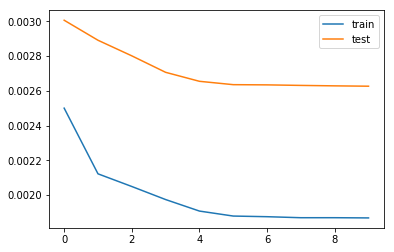

In [0]:
plt.plot(lstm_model_daily_2.history['loss'], label='train')
plt.plot(lstm_model_daily_2.history['val_loss'], label='test')
plt.legend()
plt.show()